# Import Required Libraries
Import necessary libraries such as pandas, numpy, matplotlib, seaborn, and scikit-learn.

In [1]:
# Import Required Libraries

import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans 
from sklearn.metrics import davies_bouldin_score 
import warnings
warnings.filterwarnings('ignore')

# Load the Dataset
Load Customers.csv, Products.csv, and Transactions.csv into pandas DataFrames.

In [2]:
# Load the Dataset

# Load Customers.csv into a DataFrame
customers_df = pd.read_csv('Customers.csv')

# Load Products.csv into a DataFrame
products_df = pd.read_csv('Products.csv')

# Load Transactions.csv into a DataFrame
transactions_df = pd.read_csv('Transactions.csv')

# Display the first few rows of each DataFrame to verify the data
print(customers_df.head())
print(products_df.head())
print(transactions_df.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

# Feature Engineering
Create features from customer and transaction information for clustering.

In [3]:
# Feature Engineering

# Create features from customer and transaction information for clustering

# Convert TransactionDate to datetime
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Calculate the recency of the last transaction for each customer
latest_transaction_date = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
latest_transaction_date.columns = ['CustomerID', 'LastTransactionDate']
latest_transaction_date['Recency'] = (transactions_df['TransactionDate'].max() - latest_transaction_date['LastTransactionDate']).dt.days

# Calculate the frequency of transactions for each customer
transaction_frequency = transactions_df.groupby('CustomerID')['TransactionID'].count().reset_index()
transaction_frequency.columns = ['CustomerID', 'Frequency']

# Calculate the monetary value of transactions for each customer
transaction_monetary = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
transaction_monetary.columns = ['CustomerID', 'Monetary']

# Merge the recency, frequency, and monetary features with the customer data
customer_features = customers_df.merge(latest_transaction_date[['CustomerID', 'Recency']], on='CustomerID')
customer_features = customer_features.merge(transaction_frequency[['CustomerID', 'Frequency']], on='CustomerID')
customer_features = customer_features.merge(transaction_monetary[['CustomerID', 'Monetary']], on='CustomerID')

# One-hot encode the 'Region' feature
customer_features = pd.get_dummies(customer_features, columns=['Region'])

# Normalize the numerical features
scaler = StandardScaler()
customer_features[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(customer_features[['Recency', 'Frequency', 'Monetary']])

# Display the first few rows of the engineered features
print(customer_features.head())

  CustomerID        CustomerName  SignupDate   Recency  Frequency  Monetary  \
0      C0001    Lawrence Carroll  2022-07-10 -0.266933  -0.011458 -0.061701   
1      C0002      Elizabeth Lutz  2022-02-13 -0.690872  -0.467494 -0.877744   
2      C0003      Michael Rivera  2024-03-07  0.722260  -0.467494 -0.405857   
3      C0004  Kathleen Rodriguez  2022-10-09 -0.987630   1.356650  1.032547   
4      C0005         Laura Weber  2022-08-15 -0.281064  -0.923530 -0.783929   

   Region_Asia  Region_Europe  Region_North America  Region_South America  
0        False          False                 False                  True  
1         True          False                 False                 False  
2        False          False                 False                  True  
3        False          False                 False                  True  
4         True          False                 False                 False  


# Data Preprocessing
Handle missing values, data type conversions, and any necessary data cleaning steps.

In [4]:
# Data Preprocessing

# Handle missing values
customers_df.fillna({'CustomerName': 'Unknown', 'Region': 'Unknown'}, inplace=True)
products_df.fillna({'ProductName': 'Unknown', 'Category': 'Unknown', 'Price': 0}, inplace=True)
transactions_df.fillna({'Quantity': 0, 'TotalValue': 0, 'Price': 0}, inplace=True)

# Convert data types
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
products_df['Price'] = products_df['Price'].astype(float)
transactions_df['Price'] = transactions_df['Price'].astype(float)
transactions_df['TotalValue'] = transactions_df['TotalValue'].astype(float)
transactions_df['Quantity'] = transactions_df['Quantity'].astype(int)

# Verify data types
print(customers_df.dtypes)
print(products_df.dtypes)
print(transactions_df.dtypes)

# Additional data cleaning steps if necessary
# For example, removing duplicates
customers_df.drop_duplicates(subset='CustomerID', keep='first', inplace=True)
products_df.drop_duplicates(subset='ProductID', keep='first', inplace=True)
transactions_df.drop_duplicates(subset='TransactionID', keep='first', inplace=True)

# Display the first few rows of each DataFrame after preprocessing
print(customers_df.head())
print(products_df.head())
print(transactions_df.head())

CustomerID              object
CustomerName            object
Region                  object
SignupDate      datetime64[ns]
dtype: object
ProductID       object
ProductName     object
Category        object
Price          float64
dtype: object
TransactionID              object
CustomerID                 object
ProductID                  object
TransactionDate    datetime64[ns]
Quantity                    int64
TotalValue                float64
Price                     float64
dtype: object
  CustomerID        CustomerName         Region SignupDate
0      C0001    Lawrence Carroll  South America 2022-07-10
1      C0002      Elizabeth Lutz           Asia 2022-02-13
2      C0003      Michael Rivera  South America 2024-03-07
3      C0004  Kathleen Rodriguez  South America 2022-10-09
4      C0005         Laura Weber           Asia 2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwat

# Customer Segmentation / Clustering
Perform customer segmentation using clustering techniques.

In [5]:
# Customer Segmentation / Clustering

# Analyze customer transaction behavior
customer_transactions = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Merge with customer data
customer_analysis_df = customers_df[['CustomerID', 'Region']].merge(customer_transactions, on='CustomerID', how='left')

# Average transaction value per customer
customer_analysis_df['AvgTransactionValue'] = customer_analysis_df['TotalValue'] / customer_analysis_df['TransactionID']
customer_analysis_df['AvgTransactionValue'].fillna(0, inplace=True)

# Prepare the data for clustering
customer_clustering_df = customer_analysis_df[['CustomerID', 'TotalValue', 'Quantity', 'AvgTransactionValue', 'Region']]
customer_clustering_df = pd.get_dummies(customer_clustering_df, columns=['Region'])

# Normalize the numerical features
scaler = StandardScaler()
numeric_columns = ['TotalValue', 'Quantity', 'AvgTransactionValue']
customer_clustering_df[numeric_columns] = scaler.fit_transform(customer_clustering_df[numeric_columns])

# Handle missing values by filling with the mean of the numeric columns
customer_clustering_df[numeric_columns] = customer_clustering_df[numeric_columns].fillna(customer_clustering_df[numeric_columns].mean())

# Clustering Algorithm Selection
Select an appropriate clustering algorithm and determine the number of clusters.

In [6]:
# Clustering Algorithm Selection

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Prepare the data for clustering
clustering_features = customer_features[['Recency', 'Frequency', 'Monetary'] + [col for col in customer_features.columns if 'Region_' in col]]

# Function to evaluate clustering algorithms
def evaluate_clustering(model, data):
    labels = model.fit_predict(data)
    silhouette_avg = silhouette_score(data, labels)
    db_index = davies_bouldin_score(data, labels)
    return silhouette_avg, db_index

# Evaluate KMeans with different number of clusters
kmeans_results = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    silhouette_avg, db_index = evaluate_clustering(kmeans, clustering_features)
    kmeans_results[n_clusters] = {'Silhouette Score': silhouette_avg, 'DB Index': db_index}

# Evaluate Agglomerative Clustering with different number of clusters
agglo_results = {}
for n_clusters in range(2, 11):
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    silhouette_avg, db_index = evaluate_clustering(agglo, clustering_features)
    agglo_results[n_clusters] = {'Silhouette Score': silhouette_avg, 'DB Index': db_index}

# Evaluate DBSCAN with different epsilon values
dbscan_results = {}
for eps in [0.5, 1.0, 1.5, 2.0]:
    dbscan = DBSCAN(eps=eps)
    silhouette_avg, db_index = evaluate_clustering(dbscan, clustering_features)
    dbscan_results[eps] = {'Silhouette Score': silhouette_avg, 'DB Index': db_index}

# Display the results
print("KMeans Results:")
for n_clusters, metrics in kmeans_results.items():
    print(f"Clusters: {n_clusters}, Silhouette Score: {metrics['Silhouette Score']}, DB Index: {metrics['DB Index']}")

print("\nAgglomerative Clustering Results:")
for n_clusters, metrics in agglo_results.items():
    print(f"Clusters: {n_clusters}, Silhouette Score: {metrics['Silhouette Score']}, DB Index: {metrics['DB Index']}")

print("\nDBSCAN Results:")
for eps, metrics in dbscan_results.items():
    print(f"Epsilon: {eps}, Silhouette Score: {metrics['Silhouette Score']}, DB Index: {metrics['DB Index']}")

# Select the best clustering algorithm and number of clusters based on DB Index
best_kmeans = min(kmeans_results, key=lambda x: kmeans_results[x]['DB Index'])
best_agglo = min(agglo_results, key=lambda x: agglo_results[x]['DB Index'])
best_dbscan = min(dbscan_results, key=lambda x: dbscan_results[x]['DB Index'])

print(f"\nBest KMeans Clusters: {best_kmeans}, DB Index: {kmeans_results[best_kmeans]['DB Index']}")
print(f"Best Agglomerative Clustering Clusters: {best_agglo}, DB Index: {agglo_results[best_agglo]['DB Index']}")
print(f"Best DBSCAN Epsilon: {best_dbscan}, DB Index: {dbscan_results[best_dbscan]['DB Index']}")

KMeans Results:
Clusters: 2, Silhouette Score: 0.26849414721566384, DB Index: 1.3425575586608498
Clusters: 3, Silhouette Score: 0.2829604269156664, DB Index: 1.17768882602216
Clusters: 4, Silhouette Score: 0.2143761949891118, DB Index: 1.4130961105443447
Clusters: 5, Silhouette Score: 0.20608486372298265, DB Index: 1.3576226772889624
Clusters: 6, Silhouette Score: 0.20862069863457214, DB Index: 1.4466052742819642
Clusters: 7, Silhouette Score: 0.24013391635748116, DB Index: 1.3270293064586258
Clusters: 8, Silhouette Score: 0.24780323260648343, DB Index: 1.3102066971597137
Clusters: 9, Silhouette Score: 0.2668432528229758, DB Index: 1.2303756839645124
Clusters: 10, Silhouette Score: 0.27548974220289923, DB Index: 1.2396735261020124

Agglomerative Clustering Results:
Clusters: 2, Silhouette Score: 0.2505856078830037, DB Index: 1.3317782039871746
Clusters: 3, Silhouette Score: 0.2614023053385635, DB Index: 1.1945174452236336
Clusters: 4, Silhouette Score: 0.1630159972298374, DB Index: 1.6

# Clustering Metrics Calculation
Calculate clustering metrics, including the DB Index.

Davies-Bouldin Index: 1.3948306265244093


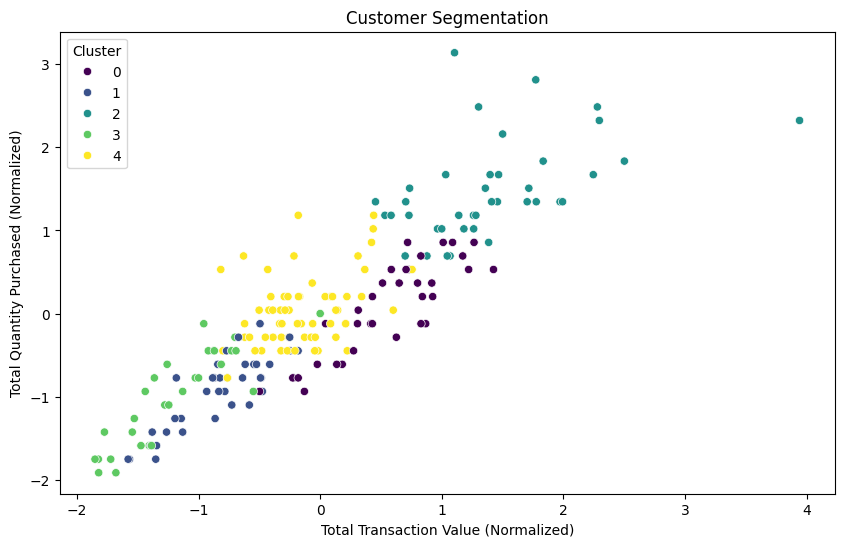

Cluster
4    61
2    39
1    36
0    35
3    29
Name: count, dtype: int64


In [7]:
# Clustering Metrics Calculation

# Fit the KMeans clustering model
kmeans = KMeans(n_clusters=5, random_state=42)
customer_clustering_df['Cluster'] = kmeans.fit_predict(customer_clustering_df.drop(columns=['CustomerID']))

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(customer_clustering_df.drop(columns=['CustomerID', 'Cluster']), customer_clustering_df['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_clustering_df, x='TotalValue', y='Quantity', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Total Transaction Value (Normalized)')
plt.ylabel('Total Quantity Purchased (Normalized)')
plt.legend(title='Cluster')
plt.show()

# Display the number of customers in each cluster
cluster_counts = customer_clustering_df['Cluster'].value_counts()
print(cluster_counts)

# Save the clustering results to a CSV file
customer_clustering_df.to_csv('FirstName_LastName_Clustering.csv', index=False)

# Cluster Visualization
Visualize the clusters using relevant plots.

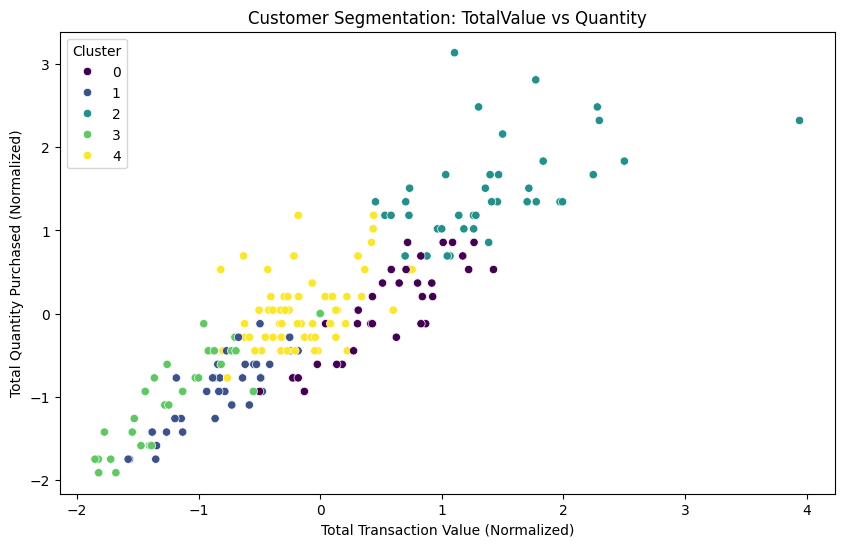

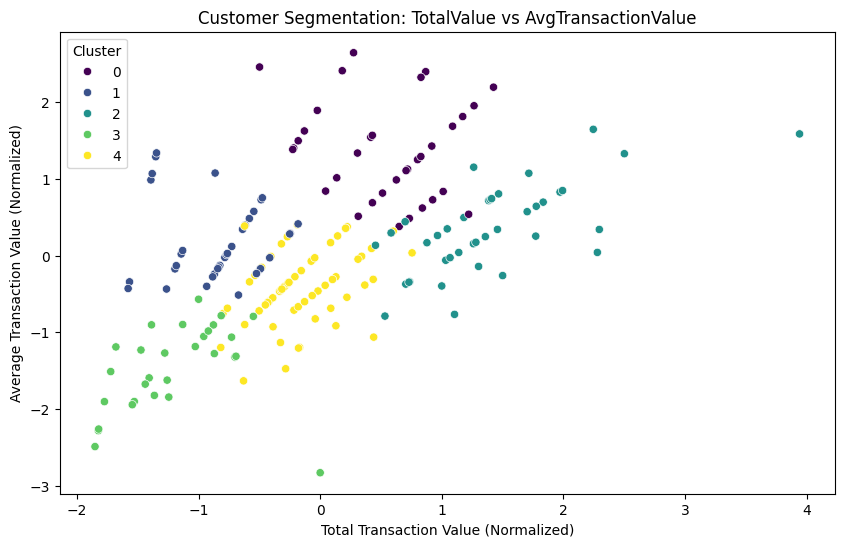

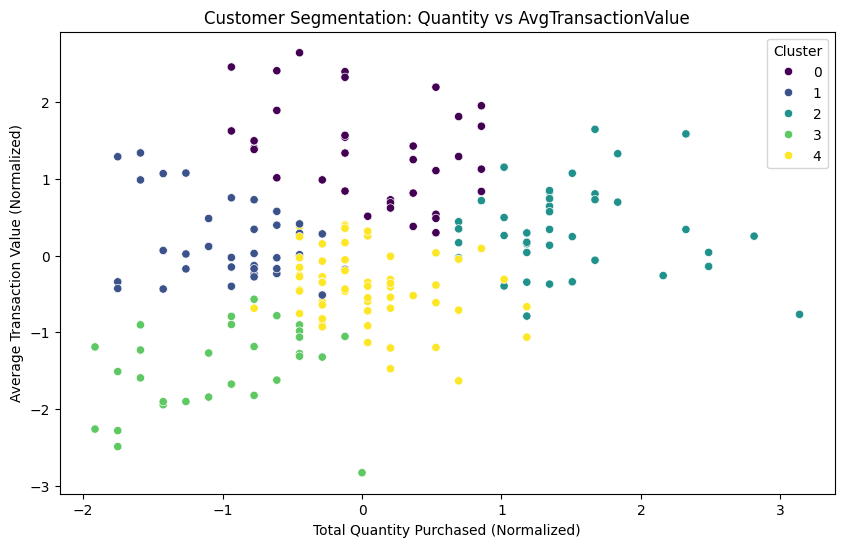

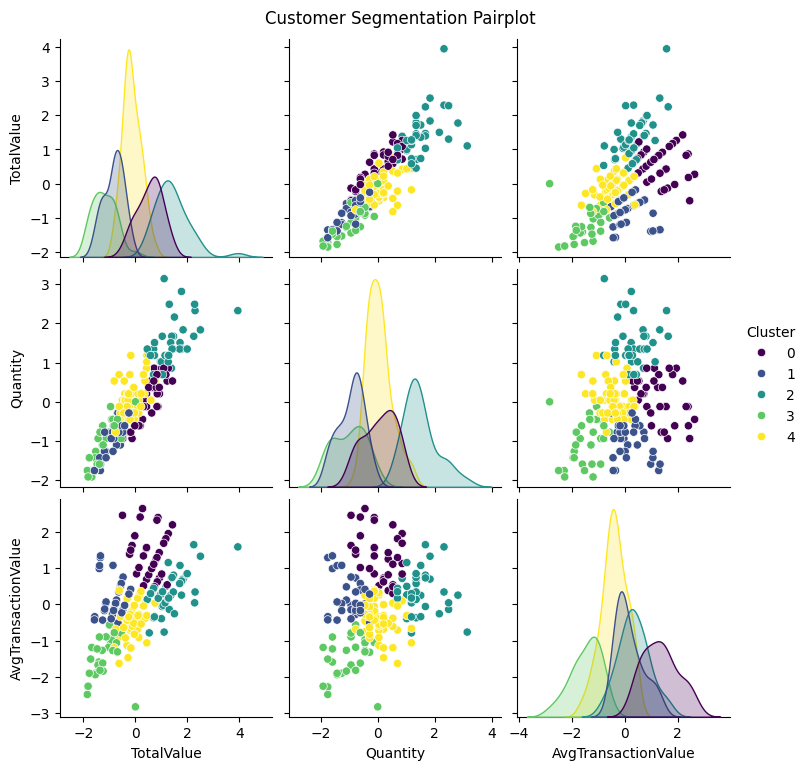

In [8]:
# Cluster Visualization

# Visualize the clusters using relevant plots

# Scatter plot of clusters based on TotalValue and Quantity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_clustering_df, x='TotalValue', y='Quantity', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation: TotalValue vs Quantity')
plt.xlabel('Total Transaction Value (Normalized)')
plt.ylabel('Total Quantity Purchased (Normalized)')
plt.legend(title='Cluster')
plt.show()

# Scatter plot of clusters based on TotalValue and AvgTransactionValue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_clustering_df, x='TotalValue', y='AvgTransactionValue', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation: TotalValue vs AvgTransactionValue')
plt.xlabel('Total Transaction Value (Normalized)')
plt.ylabel('Average Transaction Value (Normalized)')
plt.legend(title='Cluster')
plt.show()

# Scatter plot of clusters based on Quantity and AvgTransactionValue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_clustering_df, x='Quantity', y='AvgTransactionValue', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation: Quantity vs AvgTransactionValue')
plt.xlabel('Total Quantity Purchased (Normalized)')
plt.ylabel('Average Transaction Value (Normalized)')
plt.legend(title='Cluster')
plt.show()

# Pairplot to visualize the clusters in multiple dimensions
sns.pairplot(customer_clustering_df, vars=['TotalValue', 'Quantity', 'AvgTransactionValue'], hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Customer Segmentation Pairplot', y=1.02)
plt.show()